In [ ]:
# Data Analysis modules
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6
plt.figure(figsize=(12,8))
plt.style.use('seaborn-white')
%matplotlib inline
import seaborn; seaborn.set()
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import pickle
import os

# ARIMA and Time Series modules
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
import plotly.express as px

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Loading the series from csv files
df_marsa = pd.read_csv('nserie-marsa.csv', index_col= None, header=None)

In [ ]:
df_marsa

,0
0,7
1,5
2,6
3,6
4,5
...,...
104,2
105,2
106,0
107,5


In [ ]:
# Date formating: We have data from 2009 to 2018
from datetime import datetime, timedelta
import dateutil.parser

months = pd.date_range("2009-01-31", "2018-01-31", freq='M')
months = pd.to_datetime(months)
df_marsa.set_index(months, drop=True, inplace=True)

In [ ]:
df_marsa

,0
2009-01-31,7
2009-02-28,5
2009-03-31,6
2009-04-30,6
2009-05-31,5
...,...
2017-09-30,2
2017-10-31,2
2017-11-30,0
2017-12-31,5


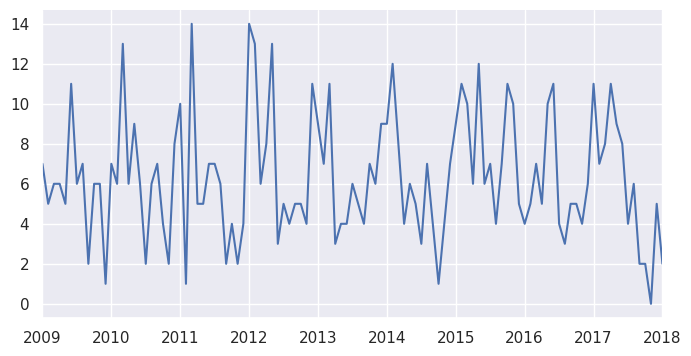

In [ ]:
# @title 0

from matplotlib import pyplot as plt
df_marsa[0].plot(kind='line', figsize=(8, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Training set: 2009-2016
# Test set: 2017
df_training, df_test = df_marsa[0][0:96], df_marsa[0][96:]

df_training = pd.DataFrame(df_training)
df_test = pd.DataFrame(df_test)

In [ ]:
from scipy.optimize import brute

# Root mean squared error
def get_rmse(y, y_hat):
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

# ARIMA Modeling
def auto_arima(endog, verbose = True,
                ranges = (slice(0,5), slice(0,2), slice(0,5), slice(0,5), slice(0,2), slice(0,5), slice(0,12))):
    global grid
    grid = []
    resultsbrute = brute(arima_modeling, ranges=ranges, args=(endog,),
                         full_output=True, finish=None)
    del grid[0]
    return resultsbrute

def arima_modeling(coeffs, *args):
    endog = args[0]
    order = coeffs[0:3].tolist()
    seasonal_order = coeffs[3:7].tolist()
    try:
        mod = SARIMAX(endog, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
        fit = mod.fit(disp=False)
        aic = fit.aic
        bic = fit.bic
        rmse = get_rmse(df_test[0], fit.predict(start = 96, end = df_test.index[-1]))
        rmse6 = get_rmse(df_test[0], fit.predict(start = 96, end = 102))
        rmse3 = get_rmse(df_test[0], fit.predict(start = 96, end = 99))
    except:
        aic, bic, rmse, rmse6, rmse3, fit =  np.inf, np.inf, np.inf, np.inf, np.inf, np.inf
    global grid
    grid.append([coeffs, aic, bic, rmse, rmse6, rmse3, fit])
    return rmse

In [ ]:
px.line(df_marsa, x=df_marsa.index, y=0)

In [ ]:
import plotly.graph_objects as go

rolmean = df_marsa.rolling(window=12).mean()
rolmean.set_index(df_marsa.index, inplace=True)

moving_average_marsa = go.Figure(data=go.Scatter(x=df_marsa.index,
                        y=rolmean[0].values,
                        marker_color='indianred', text="ma_marsa"))

moving_average_marsa.show()

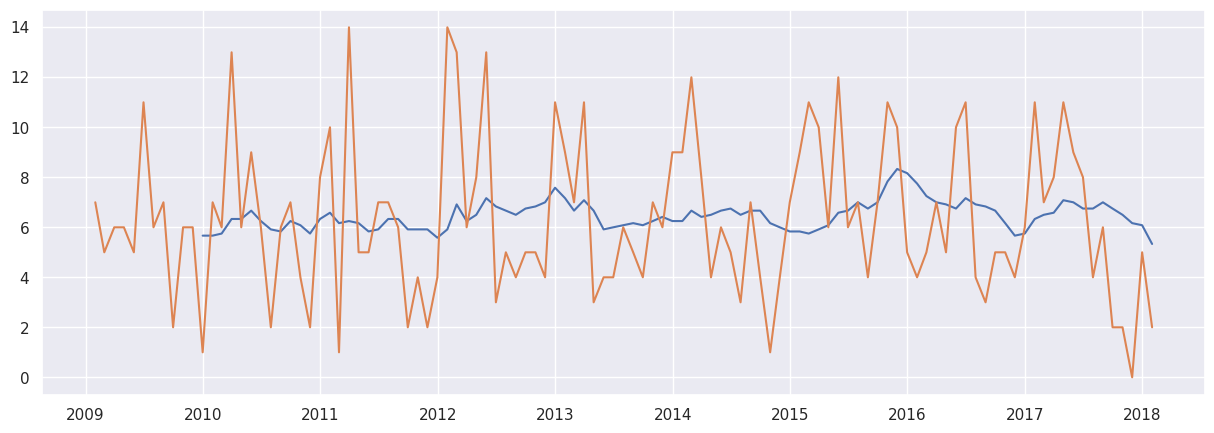

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(rolmean)
plt.plot(df_marsa)

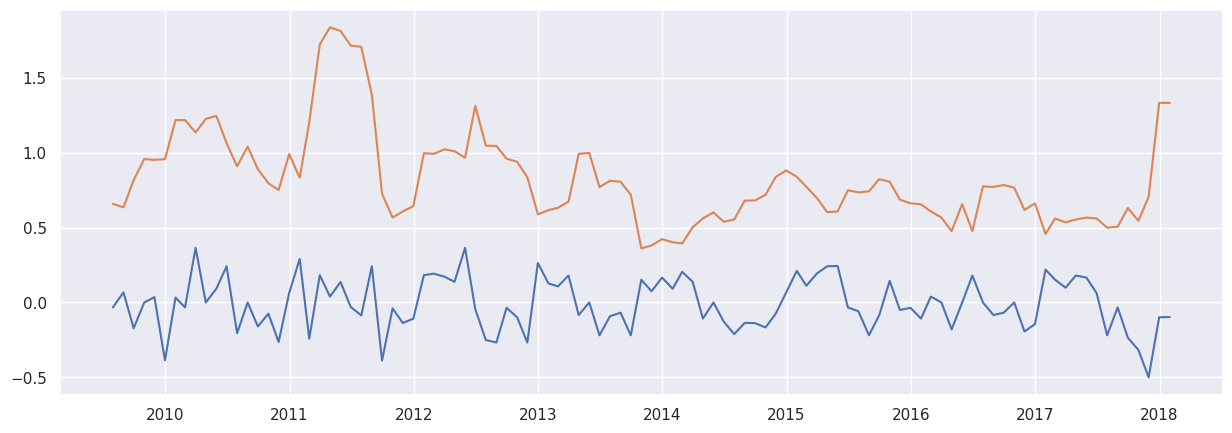

In [ ]:
df_marsa_sqrt = np.sqrt(df_marsa)
df_marsa_dif_sqrt = df_marsa_sqrt.diff()


rolstd_dif_sqrt = df_marsa_dif_sqrt.rolling(window=6).mean()
rolmean_dif_sqrt = df_marsa_dif_sqrt.rolling(window=6).std()

plt.figure(figsize=(15,5))
plt.plot(rolstd_dif_sqrt)
plt.plot(rolmean_dif_sqrt)

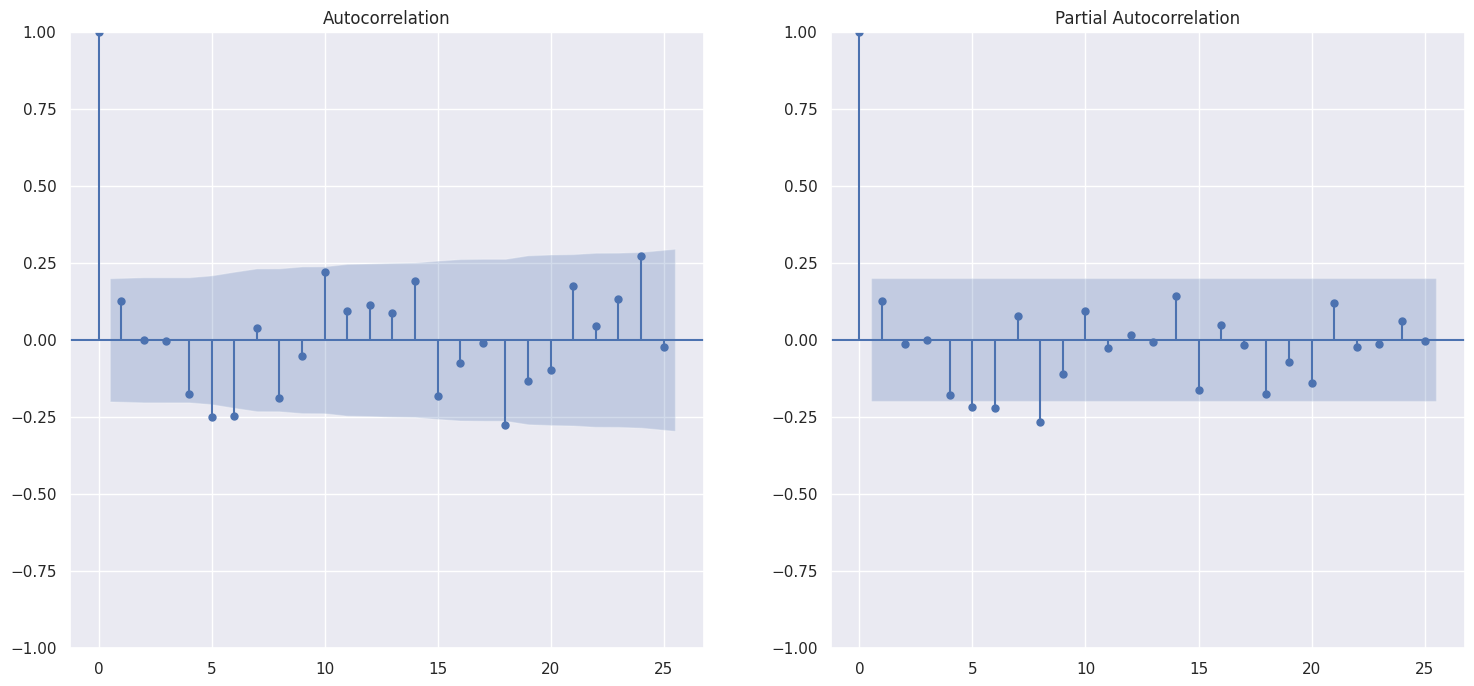

In [ ]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plot_acf(df_training, ax=plt.gca(),lags=25)
plt.subplot(122)
plot_pacf(df_training, ax=plt.gca(), lags=25)
plt.show()

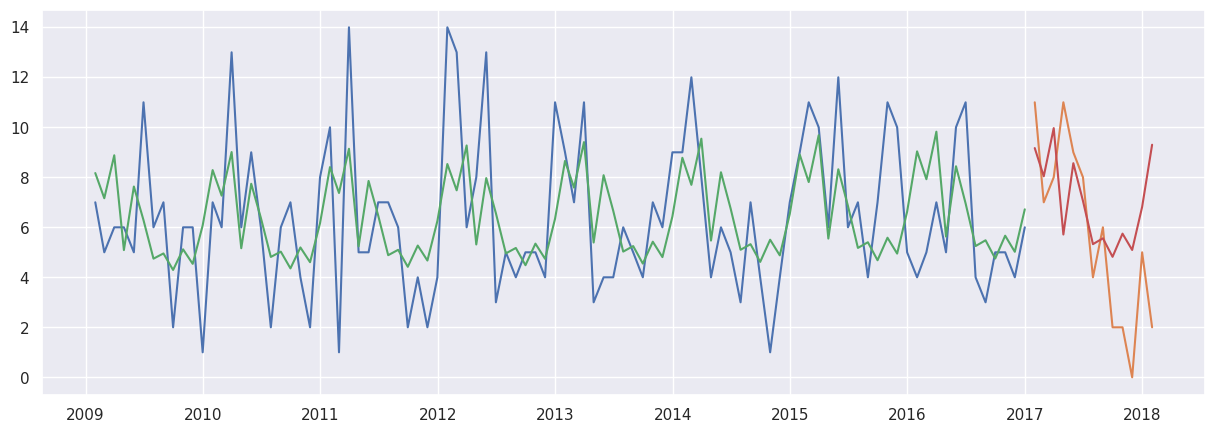

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(df_training[0], seasonal_periods=12, trend='mul', seasonal='mul').fit()
fc1 = fit1.forecast(len(df_test[0]))

plt.figure(figsize=(15,5))
plt.plot(df_training)
plt.plot(df_test[0])
plt.plot(fit1.fittedvalues)
plt.plot(fc1)

In [ ]:
fit2 = ExponentialSmoothing(df_training[0], seasonal_periods=12, trend='add', seasonal='add').fit()
fc2 = fit2.forecast(len(df_test[0]))

plt.figure(figsize=(15,5))
plt.plot(df_training)
plt.plot(df_test[0])

plt.plot(fit2.fittedvalues)
plt.plot(fc2)

NameError: name 'ExponentialSmoothing' is not defined

In [ ]:
#[2, 0, 3, 2, 0, 1, 9]
mod = SARIMAX(df_training[0], order=(2, 0, 3), seasonal_order=(2, 0, 1, 9),
                      enforce_stationarity=False, enforce_invertibility=False)
fit = mod.fit()

training = go.Scatter(
                x = df_training.index,
                y=df_training.values,
                name = "Training",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

fitted = go.Scatter(
                x = df_training.index,
                y=fit.fittedvalues,
                name = "Fitted Values",
                line = dict(color = 'red'),
                opacity = 0.8)

forecast = go.Scatter(
                x = df_test.index,
                y=fit.predict(start = 96, end = len(df_marsa)-1),
                name = "Forecast",
                line = dict(color = 'blue'),
                opacity = 0.8)

test = go.Scatter(
                x = df_test.index,
                y= df_test[0].values,
                name = "Test",
                line = dict(color = 'green'),
                opacity = 0.8)

data = [fitted, forecast, test]
fig = go.Figure(dict(data=data))
fig.show()

In [ ]:
fit.fittedvalues

2009-01-31    0.000000
2009-02-28    6.941138
2009-03-31    3.699438
2009-04-30    5.311562
2009-05-31    3.432340
                ...   
2016-08-31    3.766671
2016-09-30    5.769697
2016-10-31    5.125311
2016-11-30    6.271732
2016-12-31    9.335747
Freq: M, Length: 96, dtype: float64

In [ ]:
df_training.values

array([[ 7],
       [ 5],
       [ 6],
       [ 6],
       [ 5],
       [11],
       [ 6],
       [ 7],
       [ 2],
       [ 6],
       [ 6],
       [ 1],
       [ 7],
       [ 6],
       [13],
       [ 6],
       [ 9],
       [ 6],
       [ 2],
       [ 6],
       [ 7],
       [ 4],
       [ 2],
       [ 8],
       [10],
       [ 1],
       [14],
       [ 5],
       [ 5],
       [ 7],
       [ 7],
       [ 6],
       [ 2],
       [ 4],
       [ 2],
       [ 4],
       [14],
       [13],
       [ 6],
       [ 8],
       [13],
       [ 3],
       [ 5],
       [ 4],
       [ 5],
       [ 5],
       [ 4],
       [11],
       [ 9],
       [ 7],
       [11],
       [ 3],
       [ 4],
       [ 4],
       [ 6],
       [ 5],
       [ 4],
       [ 7],
       [ 6],
       [ 9],
       [ 9],
       [12],
       [ 8],
       [ 4],
       [ 6],
       [ 5],
       [ 3],
       [ 7],
       [ 4],
       [ 1],
       [ 4],
       [ 7],
       [ 9],
       [11],
       [10],
       [ 6],
       [12],

In [ ]:
df_training

,0
2009-01-31,7
2009-02-28,5
2009-03-31,6
2009-04-30,6
2009-05-31,5
...,...
2016-08-31,3
2016-09-30,5
2016-10-31,5
2016-11-30,4
